In [1]:
import os
import cv2
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from skimage.io import imshow, imread
from skimage import img_as_ubyte

# Histogram Equalization

In [2]:
def read_grayscale_image(path, filename):
    image = Image.open(path + filename)
    gray_image = image.convert("L")
    #plt.imshow(gray_image, cmap='gray')
    return gray_image

In [39]:
def display_hist(filename1, filename2):
    
    chest_xray_original = cv2.imread(filename1, cv2.IMREAD_GRAYSCALE)
    chest_xray_histeq = cv2.imread(filename2, cv2.IMREAD_GRAYSCALE)
    
    img_array_original = np.asarray(chest_xray_original)
    img_array_original = img_array_original.astype('int64')
    
    chest_xray_histeq = np.asarray(chest_xray_histeq)
    chest_xray_histeq = chest_xray_histeq.astype('int64')
    
    histarr_original = np.bincount(img_array_original.flatten(), minlength=256)
    histarr_histeq = np.bincount(chest_xray_histeq.flatten(), minlength=256)

    num_pixels_ori = np.sum(histarr_original)
    histarr_original = histarr_original/num_pixels_ori
    
    num_pixels_histeq = np.sum(histarr_histeq)
    histarr_histeq = histarr_histeq/num_pixels_histeq
    
    plt.plot(histarr_original, color="royalblue", label="Original")
    plt.plot(histarr_histeq, color="darkorange", label="Equalized")
    plt.title('Normalized histogram', fontsize=16)
    plt.xlabel('Pixel intensity', fontsize=14)
    plt.ylabel('Distribution', fontsize=14)
    plt.legend()
    plt.show()

In [40]:
def cumul_hist(filename1, filename2):
    
    img_original = imread(filename1)
    img_histeq = imread(filename2)
    
    cumul_hist_original = np.zeros((256,))
    cumul_hist_eq = np.zeros((256,))
    
    c = 0
    for v in range(256):
        c += (img_original==v).sum()
        cumul_hist_original[v] = c
    cumul_hist_original /= cumul_hist_original.max()
    
    c = 0
    for v in range(256):
        c += (img_histeq==v).sum()
        cumul_hist_eq[v] = c
    cumul_hist_eq /= cumul_hist_eq.max()
    
    plt.figure()
    plt.plot(cumul_hist_original, color="royalblue", label="Original")
    plt.plot(cumul_hist_eq, color="darkorange", label="Equalized")
    plt.title('Normalized cumulative histogram', fontsize=16)
    plt.xlabel('Pixel intensity', fontsize=14)
    plt.ylabel('Distribution', fontsize=14)
    plt.legend()
    plt.show()

In [4]:
def histogram_equalization(image, save_filename):
    
    # convert to NumPy array
    
    img_array = np.asarray(image)
    img_array = img_array.astype('int64')
    
    ## Normalized cumulative histogram
    
    #flatten image array and calculate histogram via binning
    histogram_array = np.bincount(img_array.flatten(), minlength=256)
    
    #normalize
    num_pixels = np.sum(histogram_array)
    histogram_array = histogram_array/num_pixels
    
    #normalized cumulative histogram
    chistogram_array = np.cumsum(histogram_array)
    
    ## Pixel mapping lookup table
    transform_map = np.floor(255 * chistogram_array).astype(np.uint8)
    
    ## Transformation
    # flatten image array into 1D list
    img_list = list(img_array.flatten())
    
    # transform pixel values to equalize
    eq_img_list = [transform_map[p] for p in img_list]

    # reshape and write back into img_array
    eq_img_array = np.reshape(np.asarray(eq_img_list), img_array.shape)
    
    ## 
    #convert NumPy array to pillow Image and write to file
    eq_img = Image.fromarray(eq_img_array, mode='L')
    plt.imshow(eq_img, cmap='gray')
    eq_img.save(save_filename)

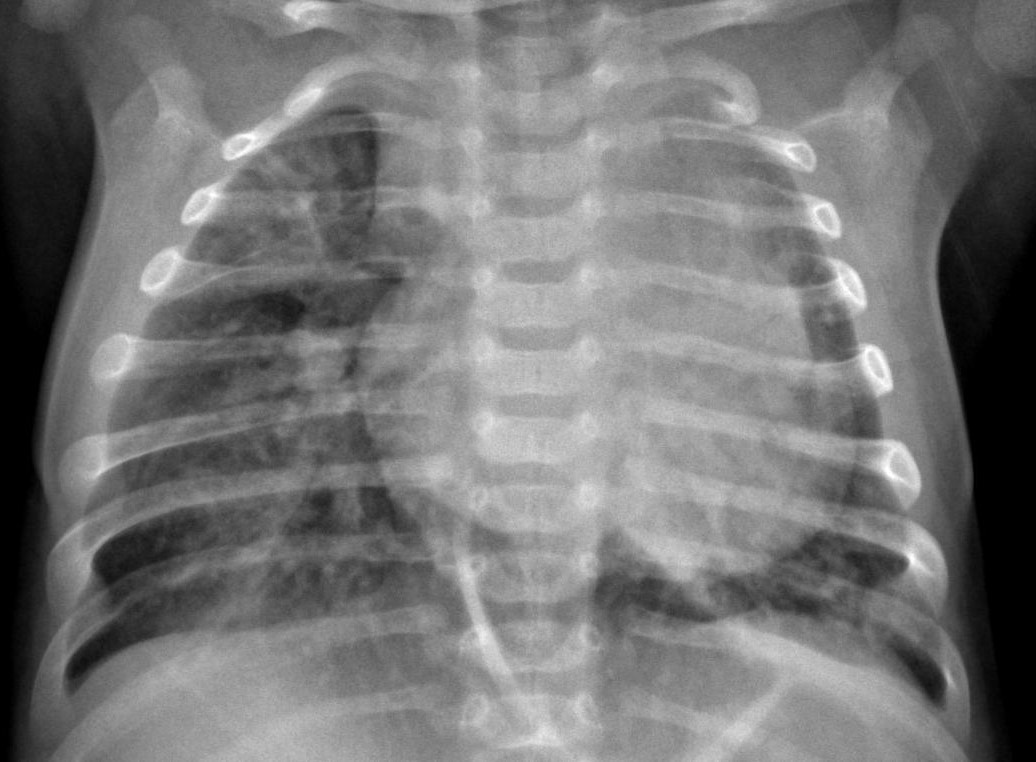

In [5]:
path = "./images/"

chest_xray = read_grayscale_image(path, 'chest-xray.jpeg')
chest_xray

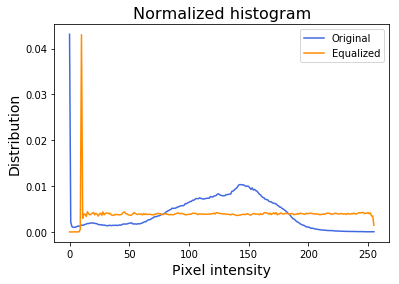

In [41]:
#chest_xray = cv2.imread("./images/chest-xray.jpeg", cv2.IMREAD_GRAYSCALE)
display_hist("./images/chest-xray.jpeg", "./images/chest-xray_hist.jpeg")

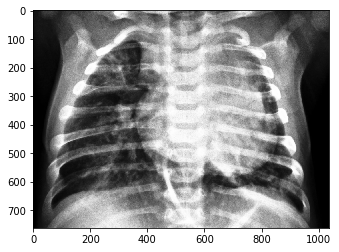

In [6]:
histogram_equalization(chest_xray, './images/chest-xray_hist.jpeg')

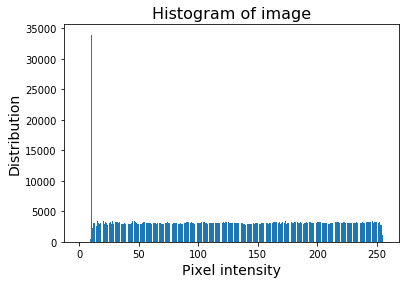

In [106]:
chest_xray_hist = cv2.imread("./images/chest-xray_hist.jpeg", cv2.IMREAD_GRAYSCALE)
display_hist(chest_xray_hist)

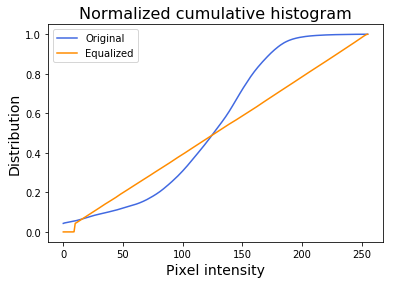

In [42]:
cumul_hist('./images/chest-xray.jpeg', './images/chest-xray_hist.jpeg')

-1

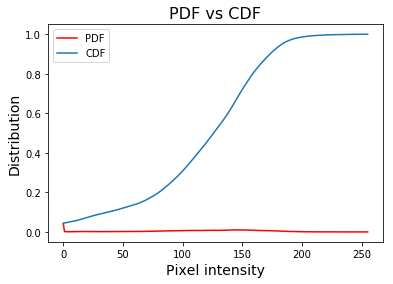

<Figure size 432x288 with 0 Axes>

In [144]:
import numpy as np
import cv2

def img_float2int(img):
    
    img = np.round(img, 0)
    img = np.minimum(img, 255)
    img = np.maximum(img, 0)
    img = img.astype('uint8')
    return img

def histogram_equalization(img):
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    histogram = np.zeros([256], np.int32) 
    
    # calculate histogram 
    for i in range(0, img_height):
        for j in range(0, img_width):
            histogram[img[i, j]] += 1
            
    # calculate probability density function (pdf) of the image
    pdf_img = histogram / histogram.sum()
    
    # calculate cumulative distribution function (cdf) 
    cdf = np.zeros([256], float)

    # For loop for cdf
    #for i in range(0, 256):
    #    for j in range(0, i+1):
    #        cdf[i] += pdf_img[j]

    # a more efficient way
    cdf = np.zeros(256, float)
    cdf[0] = pdf_img[0]
    for i in range(1, 256):
        cdf[i] = cdf[i-1] + pdf_img[i]
     
    # mapping, transformation function T(x)
    cdf_eq = np.round(cdf * 255, 0)
    
    imgEqualized = np.zeros((img_height, img_width))
    
    # for mapping input image to s
    for i in range(0, img_height):
        for j in range(0, img_width):
            r = img[i, j] # feeding intensity levels of pixels into r 
            s = cdf_eq[r] # finding value of s by finding r'th position in the cdf_eq list
            imgEqualized[i, j] = s # mapping s thus creating new output image
            
    # calculate histogram equalized image here
    # imgEqualized = s # change this
    
    plt.plot(range(0,256), pdf_img, color="red", label="PDF")
    plt.plot(range(0,256), cdf, label="CDF")
    plt.title('PDF vs CDF', fontsize=16)
    plt.xlabel('Pixel intensity', fontsize=14)
    plt.ylabel('Distribution', fontsize=14)
    plt.legend()
    
    plt.figure()
    
    return imgEqualized


# Read input image as Grayscale
img = cv2.imread('./images/chest-xray.jpeg', cv2.IMREAD_GRAYSCALE)

# obtain the histogram equalized images
img_eq = histogram_equalization(img)
img_eq = img_float2int(img_eq)

#cv2.imwrite('./images/chest-xray_hist.jpeg', img_eq)
cv2.imshow('image_hist_eq', img_eq)
cv2.waitKey()

# Add noise to image

In [70]:
# Salt-and-Pepper noise
def sp_noise(image, prob):
    
    output = np.zeros(image.shape, np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

image = cv2.imread('./images/rat.jpg', cv2.IMREAD_COLOR)
noise_img = sp_noise(image, 0.1)
cv2.imwrite('./images/rat_noise_sp.jpg', noise_img)

True

# Remove the noise by median filter and Adaptive median filter

In [61]:
def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = []
    data_final = np.zeros((len(data),len(data[0])))
    for i in range(len(data)):

        for j in range(len(data[0])):

            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final


original_img = Image.open("./images/cat_noise_sp.jpg").convert("L")
arr = np.array(original_img)
removed_noise = median_filter(arr, 3) 
img = Image.fromarray(removed_noise)

#print(img.mode)
if img.mode == "F":
    img = img.convert("RGB")

original_img.save("./images/cat_noise_sp_gray.jpg")
img.save('./images/cat_noise_sp_median_filter.jpg')
img.show()

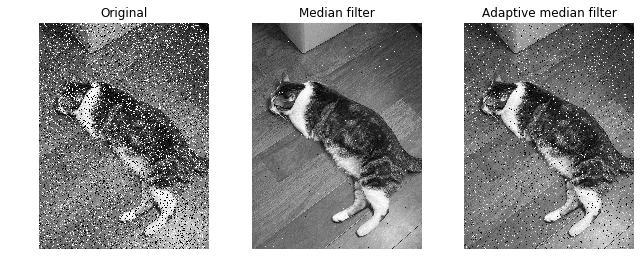

In [44]:
def filters(img):
    
    hImg = img.shape[0]
    wImg = img.shape[1]

    smax = 7
    m, n = smax, smax

    # filling image edge
    hPad = int((m-1) / 2)
    wPad = int((n-1) / 2)
    imgPad = np.pad(img.copy(), ((hPad, m-hPad-1), (wPad, n-wPad-1)), mode="edge")

    # Median filter
    imgMedianFilter = np.zeros(img.shape)

    # Adaptive median filter
    imgAdaMedFilter = np.zeros(img.shape)  

    for i in range(hPad, hPad+hImg):
        for j in range(wPad, wPad+wImg):

            # Median filter
            ksize = 3
            k = int(ksize/2)
            pad = imgPad[i-k:i+k+1, j-k:j+k+1]
            imgMedianFilter[i-hPad, j-wPad] = np.median(pad)

            # Adaptive median filter
            ksize = 3
            k = int(ksize/2)
            pad = imgPad[i-k:i+k+1, j-k:j+k+1]
            zxy = img[i-hPad][j-wPad]
            zmin = np.min(pad)
            zmed = np.median(pad)
            zmax = np.max(pad)

            if zmin < zmed < zmax:
                if zmin < zxy < zmax:
                    imgAdaMedFilter[i-hPad, j-wPad] = zxy
                else:
                    imgAdaMedFilter[i-hPad, j-wPad] = zmed
            else:
                while True:
                    ksize = ksize + 2
                    if zmin < zmed < zmax or ksize > smax:
                        break
                    k = int(ksize / 2)
                    pad = imgPad[i-k:i+k+1, j-k:j+k+1]
                    zmed = np.median(pad)
                    zmin = np.min(pad)
                    zmax = np.max(pad)
                if zmin < zmed < zmax or ksize > smax:
                    if zmin < zxy < zmax:
                        imgAdaMedFilter[i-hPad, j-wPad] = zxy
                    else:
                        imgAdaMedFilter[i-hPad, j-wPad] = zmed

    plt.figure(figsize=(9, 6))
    plt.subplot(131), plt.axis('off'), plt.title("Original")
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.subplot(132), plt.axis('off'), plt.title("Median filter")
    plt.imshow(imgMedianFilter, cmap='gray', vmin=0, vmax=255)
    plt.subplot(133), plt.axis('off'), plt.title("Adaptive median filter")
    plt.imshow(imgAdaMedFilter, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    plt.show()

img = cv2.imread("./images/cat_noise_sp_gray.jpg", cv2.IMREAD_GRAYSCALE)
filters(img)

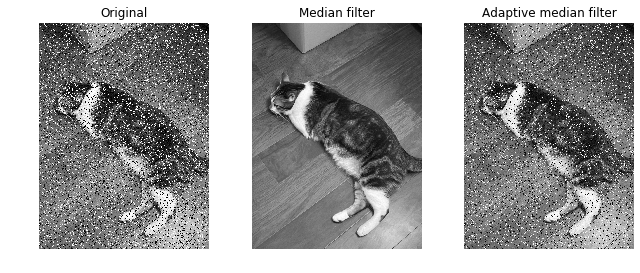

In [59]:
def filters(img):
    
    hImg = img.shape[0]
    wImg = img.shape[1]

    smax = 11
    m, n = smax, smax

    # filling image edge
    hPad = int((m-1) / 2)
    wPad = int((n-1) / 2)
    imgPad = np.pad(img.copy(), ((hPad, m-hPad-1), (wPad, n-wPad-1)), mode="edge")

    # Median filter
    imgMedianFilter = np.zeros(img.shape)

    # Adaptive median filter
    imgAdaMedFilter = np.zeros(img.shape)  

    for i in range(hPad, hPad+hImg):
        for j in range(wPad, wPad+wImg):

            # Median filter
            ksize = 7
            k = int(ksize/2)
            pad = imgPad[i-k:i+k+1, j-k:j+k+1]
            imgMedianFilter[i-hPad, j-wPad] = np.median(pad)

            # Adaptive median filter
            ksize = 7
            k = int(ksize/2)
            pad = imgPad[i-k:i+k+1, j-k:j+k+1]
            zxy = img[i-hPad][j-wPad]
            zmin = np.min(pad)
            zmed = np.median(pad)
            zmax = np.max(pad)

            if zmin < zmed < zmax:
                if zmin < zxy < zmax:
                    imgAdaMedFilter[i-hPad, j-wPad] = zxy
                else:
                    imgAdaMedFilter[i-hPad, j-wPad] = zmed
            else:
                while True:
                    ksize = ksize + 2
                    if zmin < zmed < zmax or ksize > smax:
                        break
                    k = int(ksize / 2)
                    pad = imgPad[i-k:i+k+1, j-k:j+k+1]
                    zmed = np.median(pad)
                    zmin = np.min(pad)
                    zmax = np.max(pad)
                if zmin < zmed < zmax or ksize > smax:
                    if zmin < zxy < zmax:
                        imgAdaMedFilter[i-hPad, j-wPad] = zxy
                    else:
                        imgAdaMedFilter[i-hPad, j-wPad] = zmed

    plt.figure(figsize=(9, 6))
    plt.subplot(131), plt.axis('off'), plt.title("Original")
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.subplot(132), plt.axis('off'), plt.title("Median filter")
    plt.imshow(imgMedianFilter, cmap='gray', vmin=0, vmax=255)
    plt.subplot(133), plt.axis('off'), plt.title("Adaptive median filter")
    plt.imshow(imgAdaMedFilter, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    plt.show()

img = cv2.imread("./images/cat_noise_sp_gray.jpg", cv2.IMREAD_GRAYSCALE)
filters(img)

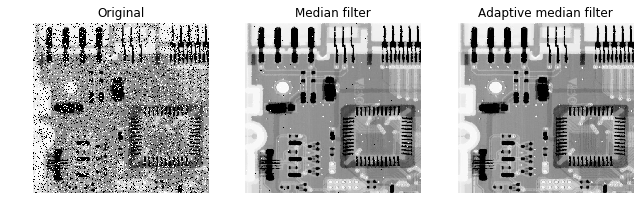

In [68]:
def filters(img):
    
    hImg = img.shape[0]
    wImg = img.shape[1]

    smax = 7
    m, n = smax, smax

    # filling image edge
    hPad = int((m-1) / 2)
    wPad = int((n-1) / 2)
    imgPad = np.pad(img.copy(), ((hPad, m-hPad-1), (wPad, n-wPad-1)), mode="edge")

    # Median filter
    imgMedianFilter = np.zeros(img.shape)

    # Adaptive median filter
    imgAdaMedFilter = np.zeros(img.shape)  

    for i in range(hPad, hPad+hImg):
        for j in range(wPad, wPad+wImg):

            # Median filter
            ksize = 3
            k = int(ksize/2)
            pad = imgPad[i-k:i+k+1, j-k:j+k+1]
            imgMedianFilter[i-hPad, j-wPad] = np.median(pad)

            # Adaptive median filter
            ksize = 3
            k = int(ksize/2)
            pad = imgPad[i-k:i+k+1, j-k:j+k+1]
            zxy = img[i-hPad][j-wPad]
            zmin = np.min(pad)
            zmed = np.median(pad)
            zmax = np.max(pad)

            if zmin < zmed < zmax:
                if zmin < zxy < zmax:
                    imgAdaMedFilter[i-hPad, j-wPad] = zxy
                else:
                    imgAdaMedFilter[i-hPad, j-wPad] = zmed
            else:
                while True:
                    ksize = ksize + 2
                    if zmin < zmed < zmax or ksize > smax:
                        break
                    k = int(ksize / 2)
                    pad = imgPad[i-k:i+k+1, j-k:j+k+1]
                    zmed = np.median(pad)
                    zmin = np.min(pad)
                    zmax = np.max(pad)
                if zmin < zmed < zmax or ksize > smax:
                    if zmin < zxy < zmax:
                        imgAdaMedFilter[i-hPad, j-wPad] = zxy
                    else:
                        imgAdaMedFilter[i-hPad, j-wPad] = zmed

    plt.figure(figsize=(9, 6))
    plt.subplot(131), plt.axis('off'), plt.title("Original")
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.subplot(132), plt.axis('off'), plt.title("Median filter")
    plt.imshow(imgMedianFilter, cmap='gray', vmin=0, vmax=255)
    plt.subplot(133), plt.axis('off'), plt.title("Adaptive median filter")
    plt.imshow(imgAdaMedFilter, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    plt.show()

img = cv2.imread("./images/book_example.tif", cv2.IMREAD_GRAYSCALE)
filters(img)

In [71]:
original_rat_img = Image.open("./images/rat_noise_sp.jpg").convert("L")
original_rat_img.save("./images/rat_noise_sp_gray.jpg")

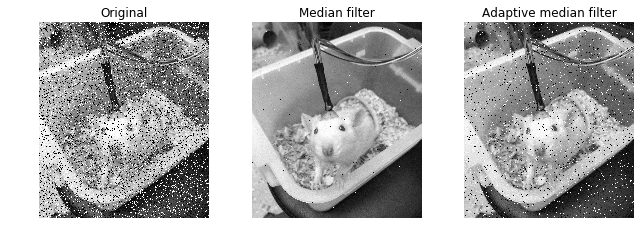

In [72]:
def filters(img):
    
    hImg = img.shape[0]
    wImg = img.shape[1]

    smax = 7
    m, n = smax, smax

    # filling image edge
    hPad = int((m-1) / 2)
    wPad = int((n-1) / 2)
    imgPad = np.pad(img.copy(), ((hPad, m-hPad-1), (wPad, n-wPad-1)), mode="edge")

    # Median filter
    imgMedianFilter = np.zeros(img.shape)

    # Adaptive median filter
    imgAdaMedFilter = np.zeros(img.shape)  

    for i in range(hPad, hPad+hImg):
        for j in range(wPad, wPad+wImg):

            # Median filter
            ksize = 3
            k = int(ksize/2)
            pad = imgPad[i-k:i+k+1, j-k:j+k+1]
            imgMedianFilter[i-hPad, j-wPad] = np.median(pad)

            # Adaptive median filter
            ksize = 3
            k = int(ksize/2)
            pad = imgPad[i-k:i+k+1, j-k:j+k+1]
            zxy = img[i-hPad][j-wPad]
            zmin = np.min(pad)
            zmed = np.median(pad)
            zmax = np.max(pad)

            if zmin < zmed < zmax:
                if zmin < zxy < zmax:
                    imgAdaMedFilter[i-hPad, j-wPad] = zxy
                else:
                    imgAdaMedFilter[i-hPad, j-wPad] = zmed
            else:
                while True:
                    ksize = ksize + 2
                    if zmin < zmed < zmax or ksize > smax:
                        break
                    k = int(ksize / 2)
                    pad = imgPad[i-k:i+k+1, j-k:j+k+1]
                    zmed = np.median(pad)
                    zmin = np.min(pad)
                    zmax = np.max(pad)
                if zmin < zmed < zmax or ksize > smax:
                    if zmin < zxy < zmax:
                        imgAdaMedFilter[i-hPad, j-wPad] = zxy
                    else:
                        imgAdaMedFilter[i-hPad, j-wPad] = zmed

    plt.figure(figsize=(9, 6))
    plt.subplot(131), plt.axis('off'), plt.title("Original")
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.subplot(132), plt.axis('off'), plt.title("Median filter")
    plt.imshow(imgMedianFilter, cmap='gray', vmin=0, vmax=255)
    plt.subplot(133), plt.axis('off'), plt.title("Adaptive median filter")
    plt.imshow(imgAdaMedFilter, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    plt.show()

img = cv2.imread("./images/rat_noise_sp_gray.jpg", cv2.IMREAD_GRAYSCALE)
filters(img)

# Color Overcast Adjustment

In [75]:
def jpg_to_png(filename, save_filenmae):
    
    img = Image.open(filename)
    img.save(save_filenmae)

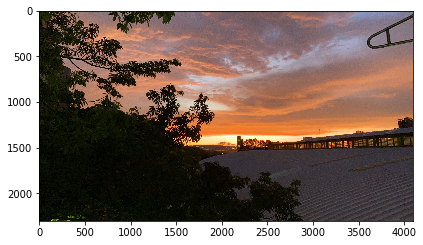

In [76]:
jpg_to_png('./images/scene.jpg', './images/scene.png')
image_scene = imread('./images/scene.png')
imshow(image_scene)

In [54]:
def channel_statistics(image):
    df_color = []
    for i in range(0, 3):
        max_color = np.max(image[:,:,i])
        mean_color = np.mean(image[:,:,i])
        median_color = np.median(image[:,:,i])
        perc_90 = np.percentile(image[:,:,i], 90, axis=(0,1))
        perc_95 = np.percentile(image[:,:,i], 95, axis=(0,1))
        perc_99 = np.percentile(image[:,:,i], 99, axis=(0,1))
        
        row = (max_color, mean_color, median_color, 
               perc_90, perc_95, perc_99)
        df_color.append(row)
        
    return pd.DataFrame(df_color, 
                        index = ['Red', ' Green', 'Blue'],
                        columns = ['Max', 'Mean', 'Median', 
                                   'P_90',' P_95', 'P_99'])
channel_statistics(image_scene)

Max       Mean  Median   P_90   P_95   P_99
Red     255  95.800207    69.0  202.0  222.0  253.0
 Green  255  72.809488    58.0  139.0  152.0  204.0
Blue    253  61.505131    59.0  128.0  150.0  188.0

In the table produced, we see that there is indeed a red overcast on the image. Now how do we balance it?

Though this will probably not work, for presentation reasons let us adjust the image via the mean, median, maximum values per channel.

C:\Users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


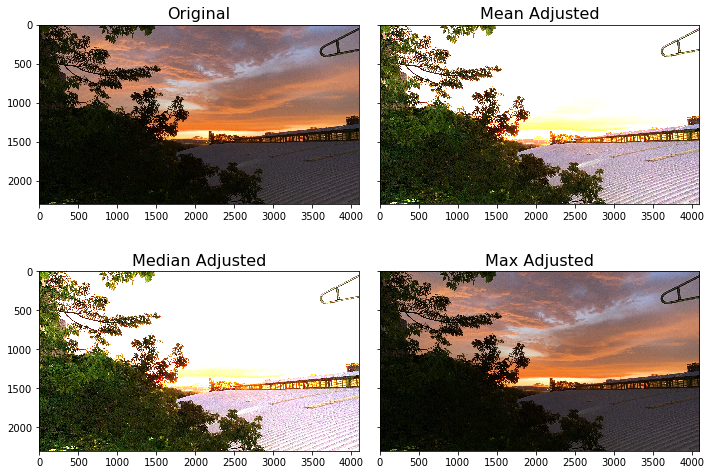

In [82]:
def mean_and_median_adjustment(image):
    fig, ax = plt.subplots(2, 2, figsize=(10, 7), sharey = True)
    f_size = 16
    ax[0][0].imshow(image)
    ax[0][0].set_title('Original', fontsize = f_size)
    ax[0][1].imshow(img_as_ubyte((image / np.mean(image)).clip(0, 1)))
    ax[0][1].set_title('Mean Adjusted', fontsize = f_size)
    
    ax[1][0].imshow(img_as_ubyte((image/ np.median(image)).clip(0, 1)))
    ax[1][0].set_title('Median Adjusted', fontsize = f_size)
    ax[1][1].imshow(img_as_ubyte((image/ np.max(image)).clip(0, 1)))
    ax[1][1].set_title('Max Adjusted', fontsize = f_size);
    
    fig.tight_layout()

mean_and_median_adjustment(image_scene)

We can see that the issue is not resolved via this method. Though one can say that the image is clearly much brighter, the red overcast is still very noticeable. One possible way to tackle this issue is by focusing on the red channel. The code below will adjust the red channel using its max value, while all the other channels are adjusted using their mean and median values.

C:\Users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


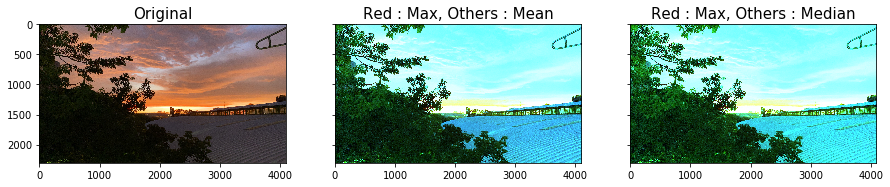

In [61]:
def redmax_adjustment(image):
    
    fig, ax = plt.subplots(1, 3, figsize=(15,7), sharey = True) 
    f_size = 15 
    ax[0].imshow(image) 
    ax[0].set_title('Original', fontsize = f_size)
    ax[1].imshow(img_as_ubyte((image / 
                               [np.max(image[:,:,0]), 
                                np.mean(image[:,:,1]), 
                                np.mean(image[:,:,2])]) 
                                .clip(0, 1)))
    ax[1].set_title('Red : Max, Others : Mean', fontsize = f_size)
    ax[2].imshow(img_as_ubyte((image / 
                               [np.max(image[:,:,0]), 
                                np.median(image[:,:,1]), 
                                np.median(image[:,:,2])]) 
                                .clip(0, 1))) 
    ax[2].set_title('Red : Max, Others : Median', fontsize = f_size)

redmax_adjustment(image_scene)

It seems that we are on the right track. The image has clearly been rid of the red overcast and is much brighter overall. However, we now see a much more pronounced overcast of green and blue. This implies that we could have adjusted red far too much, or insufficiently adjusted green and blue. It seems that we need to fine tune our parameters.

I will filter the image based on specific percentile ranks per channel.

C:\Users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


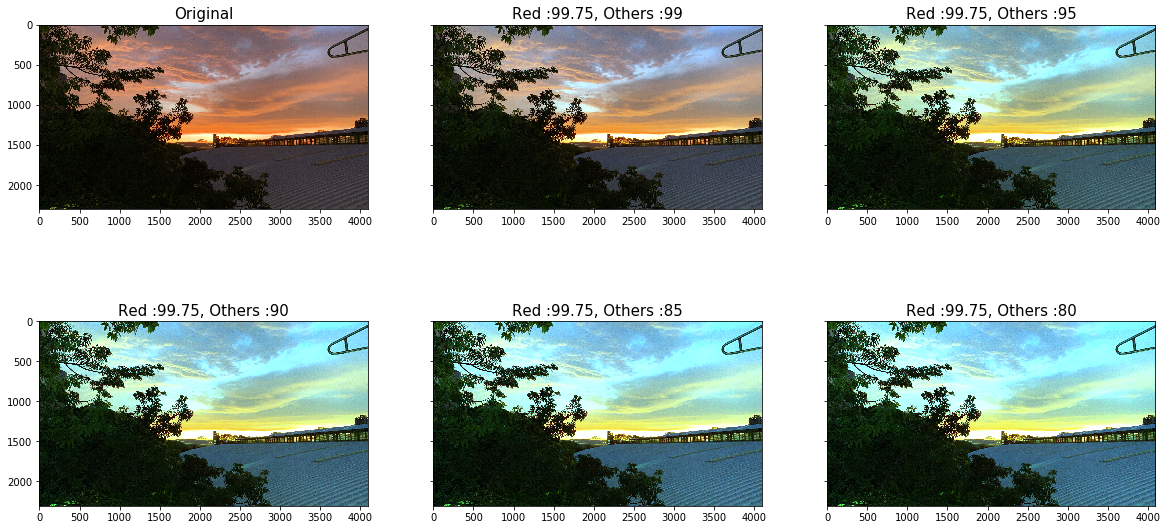

In [84]:
def percentile_adjustment(image): 
    
    fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey = True) 
    f_size = 15 
    red = 99.75   
    parameter_matrix = [[red] + [99]*3, 
                        [red] + [95]*3, 
                        [red] + [90]*3, 
                        [red] + [85]*3, 
                        [red] + [80]*3] 
    
    ax[0][0].imshow(image) 
    ax[0][0].set_title('Original', fontsize = f_size)
    ax[0][1].imshow(img_as_ubyte((image /  [np.percentile(image[:,:,i], parameter_matrix[0][i], axis=(0, 1))
                    for i in range (0, 3)]).clip(0 ,1)))
   
    ax[0][1].set_title('Red :' + str(red) + ', Others :' + str(parameter_matrix[0][1]), fontsize = f_size)
    ax[0][2].imshow(img_as_ubyte((image / [np.percentile(image[:,:,i], parameter_matrix[1][i], axis=(0, 1)) 
                     for i in range (0, 3)]).clip(0, 1))) 
    
    ax[0][2].set_title('Red :' + str(red) + ', Others :' + str(parameter_matrix[1][1]), fontsize = f_size)
    ax[1][0].imshow(img_as_ubyte((image / [np.percentile(image[:,:,i], parameter_matrix[2][i], axis=(0, 1))
                    for i in range (0, 3)]).clip(0, 1)))
    
    ax[1][0].set_title('Red :' + str(red) + ', Others :' + str(parameter_matrix[2][1]), fontsize = f_size)
    ax[1][1].imshow(img_as_ubyte((image / [np.percentile(image[:,:,i], parameter_matrix[3][i], axis=(0, 1))
                    for i in range (0, 3)]).clip(0, 1)))
    
    ax[1][1].set_title('Red :' + str(red) + ', Others :' + str(parameter_matrix[3][1]), fontsize = f_size)
    ax[1][2].imshow(img_as_ubyte((image/ [np.percentile(image[:,:,i], parameter_matrix[4][i], axis=(0, 1))
                    for i in range (0, 3)]).clip(0, 1))) 
    
    ax[1][2].set_title('Red :' + str(red) + ', Others :' + str(parameter_matrix[4][1]), fontsize = f_size);
    
percentile_adjustment(image_scene)

In [273]:
def seperate_params(image):
    
    f_size = 15
    parameter_matrix = [[99.9] + [97.75]*3, [99.75] + [92]*3]
    fig, ax = plt.subplots(2, 2, figsize=(15,6), sharey = True)
    ax[0][0].imshow(image[0:1500])
    ax[0][0].set_title('Sky Original', fontsize = f_size)
    ax[1][0].imshow(image[1500:])
    ax[1][0].set_title('Roof Original', fontsize = f_size)
    scene_correction_top = img_as_ubyte(((image[0:1500]/ [np.percentile(image[:,:,i], parameter_matrix[0][i], axis=(0, 1)) for i in range(3)]).clip(0,1)))
    ax[0][1].imshow(scene_correction_top)
    ax[0][1].set_title('Sky Adjusted', fontsize = f_size)
    scene_correction_bottom = img_as_ubyte(((image[1500:]/ [np.percentile(image[:,:,i], parameter_matrix[1][i], axis=(0, 1)) for i in range(3)]).clip(0,1)))
    ax[1][1].imshow(scene_correction_bottom)
    ax[1][1].set_title('Roof Adjusted', fontsize = f_size);
    fig.tight_layout()
    
    return scene_correction_top, scene_correction_bottom

C:\Users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


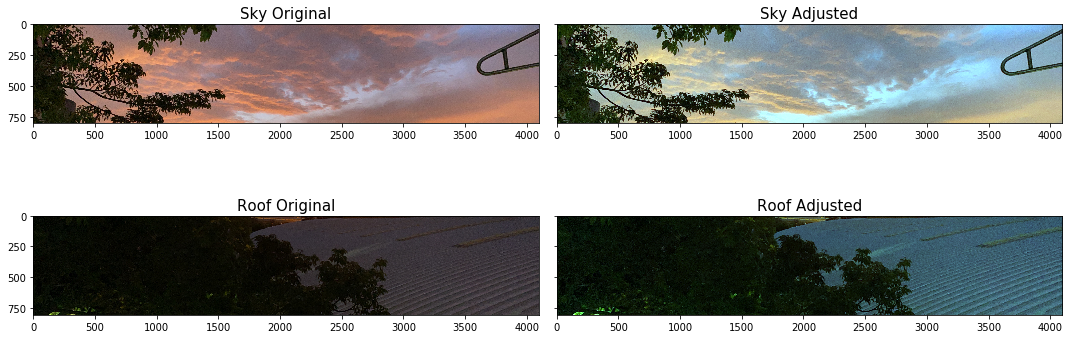

In [274]:
scene_correction_top, scene_correction_bottom = seperate_params(image_scene)

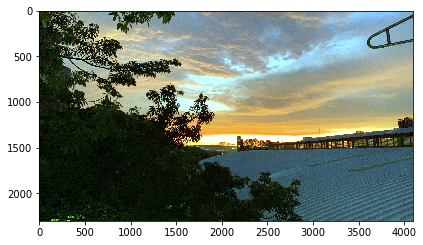

In [275]:
imshow(np.concatenate((scene_correction_top, scene_correction_bottom), axis=0))

# Morphological image processing

In [145]:
def erosion(img1):

    m, n= img1.shape 

    #plt.imshow(img1, cmap="gray")
    #plt.figure()

    # Define the structuring element
    k = 3 # different sizes of the structuring element
    SE = np.ones((k, k), dtype=np.uint8)
    constant = (k-1)//2

    # Define new image to store the pixels of eroded image
    imgErode = np.zeros((m,n), dtype=np.uint8)

    # Erosion
    for i in range(constant, m-constant):
        for j in range(constant, n-constant):
            temp = img1[i-constant:i+constant+1, j-constant:j+constant+1]
            product = temp*SE
            imgErode[i,j] = np.min(product)

    plt.imshow(imgErode, cmap="gray")
    cv2.imwrite("./images/eroded_finger.png", imgErode)
    
    return imgErode

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 255,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

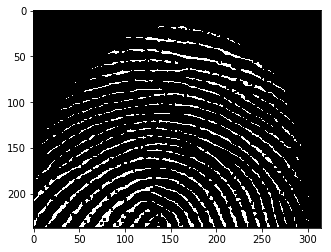

In [146]:
img_original_finger = cv2.imread("./images/noisy_fingerprint.tif", 0)
erosion(img_original_finger)

In [229]:
def erosion_test(img1):

    m, n= img1.shape 

    #plt.imshow(img1, cmap="gray")
    #plt.figure()

    # Define the structuring element
    k = 2 # different sizes of the structuring element
    SE = np.ones((k, k), dtype=np.uint8)
    constant = (k-1)//2

    # Define new image to store the pixels of eroded image
    imgErode = np.zeros((m,n), dtype=np.uint8)

    # Erosion
    for i in range(constant, m-constant):
        for j in range(constant, n-constant):
            temp = img1[i-constant:i+constant+1, j-constant:j+constant+1]
            product = temp*SE
            imgErode[i,j] = np.min(product)

    plt.imshow(imgErode, cmap="gray")
    #cv2.imwrite("./images/eroded_finger.png", imgErode)
    
    return imgErode

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255,   0,   0, ...,   0,   0,   0]], dtype=uint8)

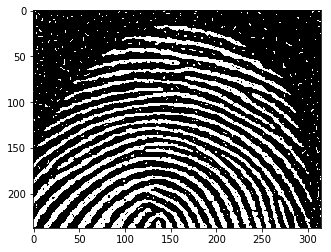

In [230]:
erosion_test(img_original_finger)

In [237]:
def dilation(img1):

    p, q = img1.shape

    #plt.imshow(img1, cmap="gray")
    #plt.figure()

    # Define new image to store the pixels of dilated image
    imgDilate = np.zeros((p,q), dtype=np.uint8)

    # Define the structuring element 
    SED = np.array([[0,1,0], [1,1,1], [0,1,0]])
    constant1 = 1

    # Dilation
    for i in range(constant1, p-constant1):
        for j in range(constant1, q-constant1):
            temp = img1[i-constant1:i+constant1+1, j-constant1:j+constant1+1]
            product = temp*SED
            imgDilate[i,j] = np.max(product)

    plt.imshow(imgDilate, cmap = "gray")
    cv2.imwrite("./images/dilated_finger.png", imgDilate)
    
    return imgDilate

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 255, 255, ..., 255, 255,   0],
       [  0,   0, 255, ..., 255, 255,   0],
       ...,
       [  0, 255, 255, ...,   0,   0,   0],
       [  0, 255, 255, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

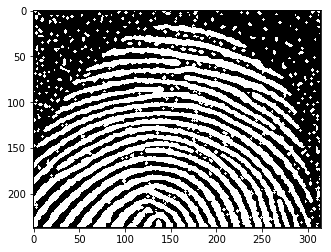

In [238]:
dilation(img_original_finger)

In [239]:
def dilation_test(img1):

    p, q = img1.shape

    #plt.imshow(img1, cmap="gray")
    #plt.figure()

    # Define new image to store the pixels of dilated image
    imgDilate = np.zeros((p,q), dtype=np.uint8)

    # Define the structuring element 
    SED = np.array([[0,0,1], [0,1,0], [0,0,0]])
    constant1 = 1

    # Dilation
    for i in range(constant1, p-constant1):
        for j in range(constant1, q-constant1):
            temp = img1[i-constant1:i+constant1+1, j-constant1:j+constant1+1]
            product = temp*SED
            imgDilate[i,j] = np.max(product)

    plt.imshow(imgDilate, cmap = "gray")
    #cv2.imwrite("./images/dilated_finger.png", imgDilate)
    
    return imgDilate

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ..., 255, 255,   0],
       [  0, 255,   0, ..., 255,   0,   0],
       ...,
       [  0, 255, 255, ...,   0,   0,   0],
       [  0, 255, 255, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

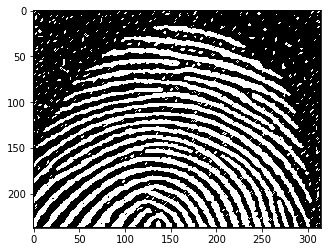

In [240]:
dilation_test(img_original_finger)

In [267]:
def opening(img1):

    m, n= img1.shape 

    #plt.imshow(img1, cmap="gray")
    #plt.figure()

    # Define the structuring element (erosion)
    k = 3 # different sizes of the structuring element
    SE = np.ones((k,k), dtype=np.uint8)
    constant = (k-1)//2
    
    # Define the structuring element (dilation)
    SED = np.array([[0,1,0], [1,1,1], [0,1,0]])
    constant1 = 1

    # Define new image to store the pixels of eroded image
    imgErode = np.zeros((m,n), dtype=np.uint8)
    # Define new image to store the pixels of opening image
    imgOpening = np.zeros((m,n), dtype=np.uint8)

    # Erosion
    for i in range(constant, m-constant):
        for j in range(constant, n-constant):
            temp = img1[i-constant:i+constant+1, j-constant:j+constant+1]
            product = temp*SE
            imgErode[i,j] = np.min(product)

    # Dilation
    for i in range(constant1, m-constant1):
        for j in range(constant1, n-constant1):
            temp = imgErode[i-constant1:i+constant1+1, j-constant1:j+constant1+1]
            product = temp*SED
            imgOpening[i,j] = np.max(product)

    plt.imshow(imgOpening, cmap = "gray")
    cv2.imwrite("./images/opening_finger.png", imgOpening)
    
    return imgOpening

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 255, 255, ...,   0,   0,   0],
       [  0, 255,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

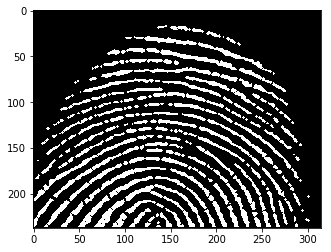

In [268]:
opening(img_original_finger)

In [245]:
def closing(img1):

    m, n= img1.shape 

    #plt.imshow(img1, cmap="gray")
    #plt.figure()

    # Define the structuring element (erosion)
    k = 3 # different sizes of the structuring element
    SE = np.ones((k,k), dtype=np.uint8)
    constant = (k-1)//2
    
    # Define the structuring element (dilation)
    SED = np.array([[0,1,0], [1,1,1], [0,1,0]])
    constant1 = 1

    # Define new image to store the pixels of dilated image
    imgDilate = np.zeros((m,n), dtype=np.uint8)
    # Define new image to store the pixels of closing image
    imgClosing = np.zeros((m,n), dtype=np.uint8)
    
    # Dilation
    for i in range(constant1, m-constant1):
        for j in range(constant1, n-constant1):
            temp = img1[i-constant1:i+constant1+1, j-constant1:j+constant1+1]
            product = temp*SED
            imgDilate[i,j] = np.max(product)

    # Erosion
    for i in range(constant, m-constant):
        for j in range(constant, n-constant):
            temp = imgDilate[i-constant:i+constant+1, j-constant:j+constant+1]
            product = temp*SE
            imgClosing[i,j] = np.min(product)

    plt.imshow(imgClosing, cmap = "gray")
    cv2.imwrite("./images/closing_finger.png", imgClosing)
    
    return imgClosing

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

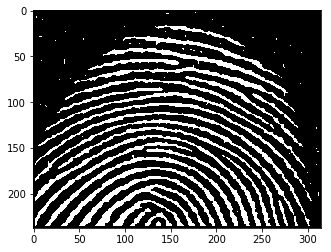

In [140]:
closing(img_original_finger)

In [263]:
def closing_changekernel(img1):

    m, n= img1.shape 

    #plt.imshow(img1, cmap="gray")
    #plt.figure()

    # Define the structuring element (erosion)
    k = 3 # different sizes of the structuring element
    SE = np.ones((k,k), dtype=np.uint8)
    constant = (k-1)//2
    
    # Define the structuring element (dilation)
    SED = np.array([[0,0,1], [0,1,0], [0,0,0]])
    constant1 = 1

    # Define new image to store the pixels of dilated image
    imgDilate = np.zeros((m,n), dtype=np.uint8)
    # Define new image to store the pixels of closing image
    imgClosing = np.zeros((m,n), dtype=np.uint8)
    
    # Dilation
    for i in range(constant1, m-constant1):
        for j in range(constant1, n-constant1):
            temp = img1[i-constant1:i+constant1+1, j-constant1:j+constant1+1]
            product = temp*SED
            imgDilate[i,j] = np.max(product)

    # Erosion
    for i in range(constant, m-constant):
        for j in range(constant, n-constant):
            temp = imgDilate[i-constant:i+constant+1, j-constant:j+constant+1]
            product = temp*SE
            imgClosing[i,j] = np.min(product)

    plt.imshow(imgClosing, cmap = "gray")
    cv2.imwrite("./images/closing_finger_change.png", imgClosing)
    
    return imgClosing

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

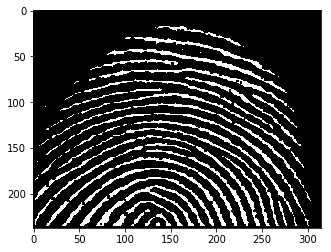

In [264]:
closing_changekernel(img_original_finger)

In [204]:
def gradient(img1):

    m, n= img1.shape 

    #plt.imshow(img1, cmap="gray")
    #plt.figure()

    # Define the structuring element (erosion)
    k = 3 # different sizes of the structuring element
    SE = np.ones((k,k), dtype=np.uint8)
    constant = (k-1)//2
    
    # Define the structuring element (dilation)
    SED = np.array([[0,1,0], [1,1,1], [0,1,0]])
    constant1 = 1
    
    # Define new image to store the pixels of eroded image
    imgErode = np.zeros((m,n), dtype=np.uint8)
    # Define new image to store the pixels of dilated image
    imgDilate = np.zeros((m,n), dtype=np.uint8)
    # Define new image to store the pixels of gradient image
    imgGradient = np.zeros((m,n), dtype=np.uint8)
    
    # Erosion
    for i in range(constant, m-constant):
        for j in range(constant, n-constant):
            temp = img1[i-constant:i+constant+1, j-constant:j+constant+1]
            product = temp*SE
            imgErode[i,j] = np.min(product)
    
    # Dilation
    for i in range(constant1, m-constant1):
        for j in range(constant1, n-constant1):
            temp = img1[i-constant1:i+constant1+1, j-constant1:j+constant1+1]
            product = temp*SED
            imgDilate[i,j] = np.max(product)
            
    imgGradient = imgErode - imgDilate

    plt.imshow(imgGradient, cmap = "gray")
    cv2.imwrite("./images/gradient_finger.png", imgGradient)


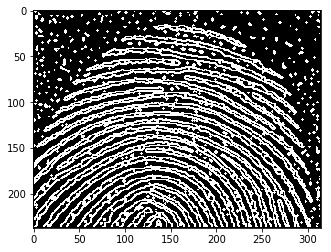

In [205]:
gradient(img_original_finger)

In [215]:
def combined(img1):
    
    imgOriginal = img1
    
    imgOpen = opening(imgOriginal)
    
    imgClose = closing(imgOriginal)
    
    imgCombined = imgOpen + imgClose
    
    plt.imshow(imgOriginal, cmap = "gray")
    plt.figure()
    plt.imshow(imgCombined, cmap = "gray")
    cv2.imwrite("./images/combined_finger.png", imgCombined)

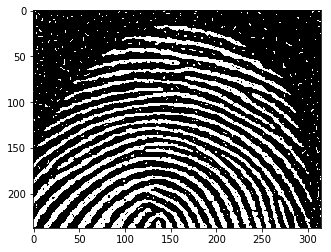

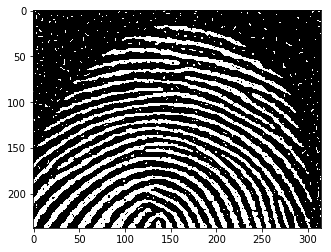

In [216]:
top_bottom_combined(img_original_finger)

In [212]:
img_combined_finger = cv2.imread("./images/combined_finger.tif", 0)

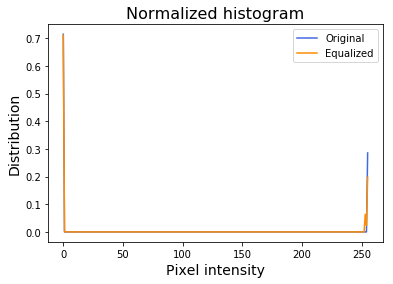

In [214]:
display_hist("./images/noisy_fingerprint.tif", "./images/combined_finger.png")